In [111]:
RUN_EVERYTHING = False # CHANGE TO TRUE YOU WOULD LIKE TO RUN THIS TO GET RESULTS YOURSELF

In [139]:
import os
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser, Superimposer, PDBIO, Select, NeighborSearch
from Bio.PDB.PDBIO import PDBIO
from rdkit import Chem
from rdkit.Chem import rdMolAlign
import matplotlib.pyplot as plt
plt.close("all")
from fragmenstein import Victor
from tqdm import tqdm
import json
import glob
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign, PandasTools
from io import StringIO
from IPython.display import display
import seaborn as sns

parser = PDBParser(QUIET=True) # Parser for PDB files
try:
    data_path = os.path.join(os.environ['RDKIT_PYROSETTA_PATH'], 'data')
except KeyError as e:
    print('You need to set RDKIT_PYROSETTA_PATH as an env variable first!')
os.chdir(data_path) # change to the directory where the data is

## Definitions

In [113]:
# definitions for ligands
def calculate_rmsd_residues(structure1, structure2):
    """Calculate RMSD between two structures from PDB files"""
    super_imposer = Superimposer()
    super_imposer.set_atoms(structure1, structure2)
    return super_imposer.rms
def calculate_rmsd_ligands(mol1, mol2):
    """Calculate RMSD between two ligands"""
    return rdMolAlign.CalcRMS(mol1, mol2) # Don't use GetBestRMS as it doesn't compare the exact conformations given
def process_ligands(mol_path1, mol_path2):
    """Checks mol paths and calculates RMSD"""
    if not os.path.exists(mol_path1):
        print(f"Files not found for {mol_path1}. Skipping.")
        return
    if not os.path.exists(mol_path2):
        print(f"Files not found for {mol_path2}. Skipping.")
        return
    # Load molecules
    mol1 = Chem.MolFromMolFile(mol_path1)
    mol2 = Chem.MolFromMolFile(mol_path2)
    if mol1 is None or mol2 is None:
        print(f"Error reading molecules for {ligand_name}. Skipping.")
        return
    # Calculate RMSD
    rmsd = calculate_rmsd_ligands(mol1, mol2)
    return rmsd

In [114]:
# definitions for residues
def calculate_center_of_mass(atoms):
    """Calculate the center of mass of a set of atoms."""
    coords = np.array([atom.coord for atom in atoms])
    center_of_mass = np.mean(coords, axis=0)
    return center_of_mass
def get_ligand_and_residues(pdb_path, ligand_resname='LIG'):
    """Parse the PDB file and extract the ligand and residues."""
    structure = parser.get_structure('structure', pdb_path)
    model = structure[0]  # Assumes single model
    ligand_atoms = []
    protein_residues = []
    for chain in model:
        for residue in chain:
            if residue.get_resname() == ligand_resname:
                ligand_atoms.extend(residue.get_atoms())
            else:
                protein_residues.append(residue)
    return ligand_atoms, protein_residues
def get_residues_within_distance(ligand_atoms, protein_residues, distance=5.0):
    """Get residues within a given distance of the ligand's center of mass."""
    center_of_mass = calculate_center_of_mass(ligand_atoms)
    ns = NeighborSearch([atom for residue in protein_residues for atom in residue.get_atoms()])
    close_residues = set()
    neighbors = ns.search(center_of_mass, distance)
    for neighbor in neighbors:
        residue = neighbor.get_parent()
        if residue not in close_residues:
            close_residues.add(residue)
    return close_residues
def match_residues(residues1, residues2):
    """Find and return matching residues between two sets of residues."""
    matched_residues1 = []
    matched_residues2 = []
    # Create dictionaries keyed by residue identifiers
    residues_dict1 = {(res.get_id(), res.get_resname()): res for res in residues1}
    residues_dict2 = {(res.get_id(), res.get_resname()): res for res in residues2}
    # Find common residues by their identifiers
    common_keys = set(residues_dict1.keys()).intersection(residues_dict2.keys())
    for key in common_keys:
        matched_residues1.append(residues_dict1[key])
        matched_residues2.append(residues_dict2[key])
    assert len(matched_residues1) == len(matched_residues2), "Mismatch in the number of matched residues."
    return matched_residues1, matched_residues2
def match_atoms(residues1, residues2):
    """Find and return matching atoms between two sets of residues."""
    matched_atoms1 = []
    matched_atoms2 = []
    for res1, res2 in zip(residues1, residues2):
        atoms1 = {atom.get_id(): atom for atom in res1.get_atoms()}
        atoms2 = {atom.get_id(): atom for atom in res2.get_atoms()}
        common_atoms = set(atoms1.keys()).intersection(atoms2.keys())
        for atom_id in common_atoms:
            matched_atoms1.append(atoms1[atom_id])
            matched_atoms2.append(atoms2[atom_id])   
    return matched_atoms1, matched_atoms2
def calculate_rmsd(residues1, residues2):
    """Calculate the RMSD between two sets of residues."""
    matched_residues1, matched_residues2 = match_residues(residues1, residues2)
    atoms1, atoms2 = match_atoms(matched_residues1, matched_residues2)      
    if not atoms1 or not atoms2:
        raise ValueError("No matching atoms found between residues.")
    super_imposer = Superimposer()
    super_imposer.set_atoms(atoms1, atoms2)
    return super_imposer.rms
def process_holos(pdb_path1, pdb_path2, ligand_resname='LIG', distance=8.0):
    """Checks pdb paths and calculates RMSD of the neighbouring residues of the ligand"""
    if not os.path.exists(pdb_path1):
        print(f"Files not found for {pdb_path1}. Skipping.")
        return
    if not os.path.exists(pdb_path2):
        print(f"Files not found for {pdb_path2}. Skipping.")
        return
    # Get lists of ligand atoms and protein residues
    ligand_atoms1, protein_residues1 = get_ligand_and_residues(pdb_path1, ligand_resname)
    ligand_atoms2, protein_residues2 = get_ligand_and_residues(pdb_path2, ligand_resname)
    # Get residues within a given distance of the ligand's center of mass
    close_residues1 = get_residues_within_distance(ligand_atoms1, protein_residues1, distance)
    close_residues2 = get_residues_within_distance(ligand_atoms2, protein_residues2, distance)
    # Calculate RMSD between the residues
    rmsd = calculate_rmsd(close_residues1, close_residues2)
    return rmsd

## Untar the data

In [115]:
# Commenting as I only want to run once
if not os.path.exists('rdkit_place'):
    !tar -xzvf rdkit_place.tar.gz
else:
    print('rdkit_place exists')

rdkit_place exists


In [116]:
# Commenting as I only want to run once
if not os.path.exists('pyrosetta_place'):
    !tar -xzvf pyrosetta_place.tar.gz
else:
    print('pyrosetta_place exists')

pyrosetta_place exists


## Calculating RMSD of ligands between RDKit and PyRosetta

Since each ligand was placed 10 times, a full cartesian comparison between every single placement is carried out here. Where for every placement by rdkit for a ligand, the RMSD is calculated for all 10 placements by PyRosetta. 

In [117]:
# list of all ligand names
ligand_names_w_num = list(pd.read_csv('rdkit_place.csv', index_col=0).name)
ligand_names = list(set([l_name.rsplit('-', 1)[0] for l_name in ligand_names_w_num]))
print('number of unique ligands:', len(ligand_names))

number of unique ligands: 69


In [118]:
if RUN_EVERYTHING is True:
    rdkit_paths = []
    pyrosetta_paths = []
    rmsd_name = []
    rmsd_values = []
    rdkit_name = []
    pyrosetta_name = []
    # Full cartesian comparison
    for i in range(0, 69): # 69 ligands
        ligand_name = ligand_names[i]
        for i in range(0, 10): # 10 placements by rdkit
            rdkit_ligand_name = f'{ligand_name}-{i}'
            rdkit_path = os.path.join(os.curdir, 'rdkit_place', rdkit_ligand_name, f'{rdkit_ligand_name}.minimised.mol')
            for j in range(0, 10): # 10 other placements by PyRosetta to compare to
                pyrosetta_ligand_name = f'{ligand_name}-{j}'
                pyrosetta_path = os.path.join(os.curdir, 'pyrosetta_place', pyrosetta_ligand_name, f'{pyrosetta_ligand_name}.minimised.mol')
                rmsd = process_ligands(rdkit_path, pyrosetta_path)
                rdkit_paths.append(rdkit_path)
                pyrosetta_paths.append(pyrosetta_path)
                rdkit_name.append(rdkit_ligand_name)
                pyrosetta_name.append(pyrosetta_ligand_name)
                rmsd_name.append(f'{ligand_name}_rdkit-{i}_pyrosetta-{j}')
                rmsd_values.append(rmsd)
    
    ligand_df = pd.DataFrame({'name': rmsd_name, 'rdkit_name': rdkit_name, 'pyrosetta_name': pyrosetta_name, 'rdkit_path': rdkit_path, 'pyrosetta_path': pyrosetta_path, 'ligand_rmsd': rmsd_values})
else:
    ligand_df = pd.read_csv('../results/ligand_rmsd.csv', index_col=0)
ligand_df

,name,rdkit_name,pyrosetta_name,rdkit_path,pyrosetta_path,ligand_rmsd,rdkit_comRMSD,pyrosetta_comRMSD
0,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.713461,0.877480,0.663325
1,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-1,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-1,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.712547,0.877480,0.663665
2,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-2,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-2,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.732352,0.877480,0.654336
3,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-3,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-3,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.613934,0.877480,0.661251
4,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-4,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-4,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.707882,0.877480,0.663417
...,...,...,...,...,...,...,...,...
6895,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-5,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-5,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.288576,0.747606,0.693922
6896,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-6,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-6,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.285928,0.747606,0.685882
6897,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-7,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.283764,0.747606,0.681948
6898,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-8,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-8,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.312672,0.747606,0.699535


Text(0.5, 0, 'RMSD')

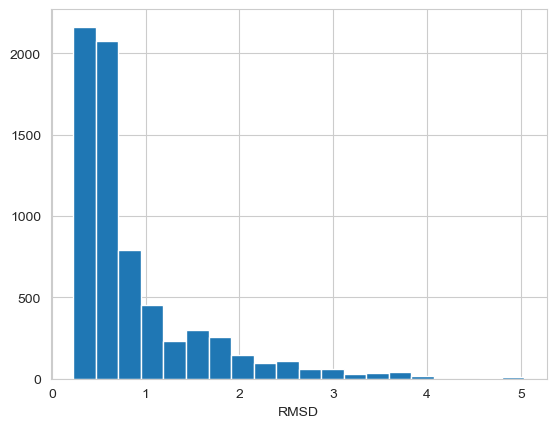

In [119]:
# Visualize the RMSD values
ligand_df['ligand_rmsd'].hist(bins=20)
plt.xlabel('RMSD')

# Add comRMSD to fragments of each ligand placement 

Fragmenstein calculates the combined RMSD of matched atoms in the ligand to the fragment inspiration, `comRMSD`. If two atoms match in different fragments to the same atom in the ligand, the match with the shorter distance is included in the RMSD calculation.

In [120]:
# create dictionaries of comRMSD values
rdkit_place = pd.read_csv('rdkit_place.csv', index_col=0)
rdkit_comRMSD = rdkit_place.set_index('name')['comRMSD'].to_dict()
pyrosetta_place = pd.read_csv('pyrosetta_place.csv', index_col=0)
pyrosetta_place_clean = pyrosetta_place.dropna(subset=['name', 'comRMSD']) # corrupt .csv 
pyrosetta_comRMSD = pyrosetta_place_clean.set_index('name')['comRMSD'].to_dict()

In [121]:
# add values to ligand_df
ligand_df['rdkit_comRMSD'] = ligand_df['rdkit_name'].map(rdkit_comRMSD)
ligand_df['pyrosetta_comRMSD'] = ligand_df['pyrosetta_name'].map(pyrosetta_comRMSD)

Text(0.5, 0, 'comRMSD value')

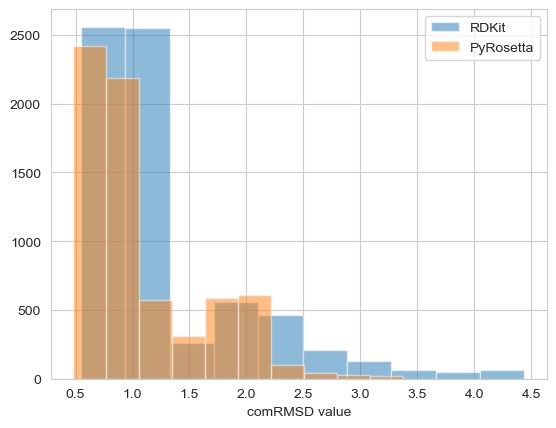

In [122]:
ligand_df['rdkit_comRMSD'].hist(alpha=0.5, label='RDKit')
ligand_df['pyrosetta_comRMSD'].hist(alpha=0.5, label='PyRosetta')
plt.legend()
plt.xlabel('comRMSD value')

## Calculating RMSD of residues between RDKit and PyRosetta

In [123]:
if RUN_EVERYTHING is True:
    rdkit_paths = []
    pyrosetta_paths = []
    rmsd_name = []
    rmsd_values = []
    rdkit_name = []
    pyrosetta_name = []
    # Full cartesian comparison
    for i in tqdm(range(69), desc="Ligands"):  # 69 ligands
        ligand_name = ligand_names[i]
        for i in range(0, 10): # 10 placements of pyrosetta
            rdkit_ligand_name = f'{ligand_name}-{i}'
            rdkit_path = os.path.join(os.curdir, 'rdkit_place', rdkit_ligand_name, f'{rdkit_ligand_name}.holo_minimised.pdb')
            for j in range(0, 10): # 10 other placements by PyRosetta to compare to
                pyrosetta_ligand_name = f'{ligand_name}-{j}'
                pyrosetta_path = os.path.join(os.curdir, 'pyrosetta_place', pyrosetta_ligand_name, f'{pyrosetta_ligand_name}.holo_minimised.pdb')
                rmsd = process_holos(rdkit_path, pyrosetta_path)
                rdkit_paths.append(rdkit_path)
                pyrosetta_paths.append(pyrosetta_path)
                rdkit_name.append(rdkit_ligand_name)
                pyrosetta_name.append(pyrosetta_ligand_name)
                rmsd_name.append(f'{ligand_name}_rdkit-{i}_pyrosetta-{j}')
                rmsd_values.append(rmsd)
    residue_df = pd.DataFrame({'name': rmsd_name, 'rdkit_name': rdkit_name, 'pyrosetta_name': pyrosetta_name, 'rdkit_path': rdkit_paths, 'pyrosetta_path': pyrosetta_paths, 'residue_rmsd': rmsd_values})
else:
    residue_df = pd.read_csv('../results/residue_rmsd.csv', index_col=0)
residue_df

,name,rdkit_name,pyrosetta_name,rdkit_path,pyrosetta_path,residue_rmsd
0,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.663114
1,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-1,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-1,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.663915
2,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-2,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-2,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.665571
3,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-3,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-3,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.752023
4,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-4,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-4,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.663129
...,...,...,...,...,...,...
6895,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-5,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-5,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.429821
6896,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-6,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-6,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.429834
6897,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-7,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.429802
6898,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-8,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-8,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.650310


Text(0.5, 0, 'RMSD')

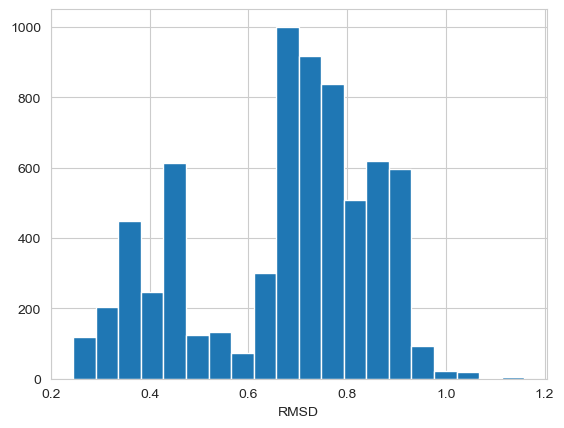

In [124]:
# Visualize the RMSD values
plt.figure()
residue_df['residue_rmsd'].hist(bins=20)
plt.xlabel('RMSD')

In [125]:
# Save the dataframes
ligand_df.to_csv('../results/ligand_rmsd.csv')
residue_df.to_csv('../results/residue_rmsd.csv')

In [126]:
# Merge the dataframes
if {'rdkit_name', 'pyrosetta_name'}.issubset(residue_df.columns):
    residue_df = residue_df.drop(columns=['rdkit_name', 'pyrosetta_name'])
merged_df = ligand_df.merge(residue_df, on='name', suffixes=('_mol', '_pdb'))
merged_df = merged_df[['name', 'rdkit_name', 'pyrosetta_name', 'rdkit_path_mol', 'pyrosetta_path_mol', 'rdkit_path_pdb', 'pyrosetta_path_pdb', 'ligand_rmsd', 'rdkit_comRMSD', 'pyrosetta_comRMSD', 'residue_rmsd']]
merged_df.to_csv('../results/merged_rmsd.csv')
merged_df

,name,rdkit_name,pyrosetta_name,rdkit_path_mol,pyrosetta_path_mol,rdkit_path_pdb,pyrosetta_path_pdb,ligand_rmsd,rdkit_comRMSD,pyrosetta_comRMSD,residue_rmsd
0,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.713461,0.877480,0.663325,0.663114
1,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-1,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-1,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.712547,0.877480,0.663665,0.663915
2,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-2,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-2,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.732352,0.877480,0.654336,0.665571
3,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-3,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-3,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.613934,0.877480,0.661251,0.752023
4,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-4,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-4,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.707882,0.877480,0.663417,0.663129
...,...,...,...,...,...,...,...,...,...,...,...
6895,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-5,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-5,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.288576,0.747606,0.693922,0.429821
6896,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-6,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-6,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.285928,0.747606,0.685882,0.429834
6897,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-7,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.283764,0.747606,0.681948,0.429802
6898,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-8,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-8,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.312672,0.747606,0.699535,0.650310


## Store ∆∆G of PyRosetta placement in a separate dataframe parsed from JSON files
Note: Had to do this since the pyrosetta_place.csv file was buggy where the number of rows >690

In [127]:
# get the ∆∆G values from the JSON files for PyRosetta placements
json_files = glob.glob('pyrosetta_place/*/*.minimised.json')
ligand_names = []
ddg_values = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    ligand_name = file.split('/')[-2]
    bound_score = data['Energy']['bound']['total_score']
    unbound_score = data['Energy']['unbound']['total_score']
    ddg = bound_score - unbound_score
    ligand_names.append(ligand_name)
    ddg_values.append(ddg)
pyrosetta_ddg = pd.DataFrame({'pyrosetta_name': ligand_names, 'pyrosetta_∆∆G': ddg_values})
pyrosetta_ddg

,pyrosetta_name,pyrosetta_∆∆G
0,UASLKFQKYXHLQJ-UHFFFAOYSA-N-0,-6.192110
1,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,-7.562787
2,APPQVEGAZDMLRK-UHFFFAOYSA-N-7,-9.528780
3,WMXYYSIGMVYKFL-UHFFFAOYSA-N-0,-0.762049
4,BHKVBKDDVLQZCR-UHFFFAOYSA-N-8,-7.650021
...,...,...
683,AVXQRKTXSXBNPP-UHFFFAOYSA-N-0,-8.365308
684,AVXQRKTXSXBNPP-UHFFFAOYSA-N-9,-8.206977
685,CVBLKWHDGHXHMC-UHFFFAOYSA-N-7,-2.232173
686,WBDILGJJGDRLFR-UHFFFAOYSA-N-9,-10.381585


In [128]:
# get the ∆∆G values from the CSV file for RDKit placements
rdkit_ddg = pd.read_csv('rdkit_place.csv', index_col=0)[['name', '∆∆G']]
rdkit_ddg.rename(columns={'∆∆G': 'rdkit_∆∆G', 'name': 'rdkit_name'}, inplace=True)
rdkit_ddg

,rdkit_name,rdkit_∆∆G
0,LXINEYASRREWNB-UHFFFAOYSA-N-0,-33.849750
1,LXINEYASRREWNB-UHFFFAOYSA-N-1,-33.849750
2,LXINEYASRREWNB-UHFFFAOYSA-N-2,-33.849750
3,LXINEYASRREWNB-UHFFFAOYSA-N-3,-33.849750
4,LXINEYASRREWNB-UHFFFAOYSA-N-4,-33.849750
...,...,...
685,YIPNWJATCFTMPP-UHFFFAOYSA-N-5,-1.021015
686,YIPNWJATCFTMPP-UHFFFAOYSA-N-6,-1.422781
687,YIPNWJATCFTMPP-UHFFFAOYSA-N-7,-8.832835
688,YIPNWJATCFTMPP-UHFFFAOYSA-N-8,8.072632


In [129]:
# Add ddG values for each ligand
merged_df = pd.read_csv('../results/merged_rmsd.csv', index_col=0)
merged_df = merged_df.merge(rdkit_ddg, how='left', on='rdkit_name')
merged_df = merged_df.merge(pyrosetta_ddg, how='left', on='pyrosetta_name')
merged_df

,name,rdkit_name,pyrosetta_name,rdkit_path_mol,pyrosetta_path_mol,rdkit_path_pdb,pyrosetta_path_pdb,ligand_rmsd,rdkit_comRMSD,pyrosetta_comRMSD,residue_rmsd,rdkit_∆∆G,pyrosetta_∆∆G
0,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.713461,0.877480,0.663325,0.663114,-31.530551,-13.518582
1,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-1,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-1,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.712547,0.877480,0.663665,0.663915,-31.530551,-13.536207
2,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-2,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-2,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.732352,0.877480,0.654336,0.665571,-31.530551,-13.489820
3,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-3,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-3,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.613934,0.877480,0.661251,0.752023,-31.530551,-11.016834
4,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-4,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-4,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.707882,0.877480,0.663417,0.663129,-31.530551,-13.511739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-5,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-5,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.288576,0.747606,0.693922,0.429821,-33.541464,-7.598472
6896,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-6,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-6,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.285928,0.747606,0.685882,0.429834,-33.541464,-7.580355
6897,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-7,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.283764,0.747606,0.681948,0.429802,-33.541464,-7.562787
6898,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-8,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-8,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.312672,0.747606,0.699535,0.650310,-33.541464,-7.680108


In [130]:
# Save the merged dataframe
merged_df.to_csv('../results/merged_rmsd_ddg.csv')

## Add PoseBusters checks for the ligands

In [131]:
# create SDF of rdkit ligands with name as title
if not os.path.exists('rdkit_place.sdf'):
    rdkit_sdf = Chem.SDWriter('rdkit_place.sdf')
    for ligand in ligand_names_w_num:
        mol = Chem.MolFromMolFile(f'rdkit_place/{ligand}/{ligand}.minimised.mol')
        mol.SetProp('_Name', ligand)
        rdkit_sdf.write(mol)
    rdkit_sdf.close()
else:
    print('rdkit_place.sdf exists')
if not os.path.exists('pyrosetta_place.sdf'):
    pyrosetta_sdf = Chem.SDWriter('pyrosetta_place.sdf')
    for ligand in ligand_names_w_num:
        if not os.path.exists(f'pyrosetta_place/{ligand}/{ligand}.minimised.mol'):
            print(f"Files not found for {ligand}. Skipping.")
            continue
        mol = Chem.MolFromMolFile(f'pyrosetta_place/{ligand}/{ligand}.minimised.mol')
        mol.SetProp('_Name', ligand)
        pyrosetta_sdf.write(mol)
    pyrosetta_sdf.close()
else:
    print('pyrosetta_place.sdf exists')

rdkit_place.sdf exists
pyrosetta_place.sdf exists


In [132]:
# Run PoseBusters
if not os.path.exists('rdkit_place_posebusters.csv'):
    !bust rdkit_place.sdf --outfmt csv --output rdkit_place_posebusters.csv
else:
    print('rdkit_place_posebusters.csv exists')

rdkit_place_posebusters.csv exists


In [133]:
if not os.path.exists('pyrosetta_place_posebusters.csv'):
    !bust pyrosetta_place.sdf --outfmt csv --output pyrosetta_place_posebusters.csv
else:
    print('pyrosetta_place_posebusters.csv exists')

pyrosetta_place_posebusters.csv exists


In [134]:
# merge the posebusters data
merged_df = pd.read_csv('../results/merged_rmsd_ddg.csv', index_col=0)
rdkit_posebusters = pd.read_csv('rdkit_place_posebusters.csv', index_col=0)
pyrosetta_posebusters = pd.read_csv('pyrosetta_place_posebusters.csv', index_col=0)
def get_passing(row, full):
    if full:
        # checks all the posebusters checks
        if row['mol_pred_loaded'] and row['sanitization'] and row['all_atoms_connected'] and row['bond_lengths'] and row['bond_angles'] and row['internal_steric_clash'] and row['aromatic_ring_flatness'] and row['aromatic_ring_flatness'] and row['internal_energy']:
            return True
    else:
        # doesnt check double bond flatness or internal energy (these are the checks implemented in Syndirella)
        if row['mol_pred_loaded'] and row['sanitization'] and row['all_atoms_connected'] and row['bond_lengths'] and row['bond_angles'] and row['internal_steric_clash'] and row['aromatic_ring_flatness']:
            return True
    return False

rdkit_posebusters['intra_geom_pass'] = rdkit_posebusters.apply(lambda x: get_passing(x, False), axis=1) # doesnt check double bond flatness or internal energy (these are the checks implemented in Syndirella)
pyrosetta_posebusters['intra_geom_pass'] = pyrosetta_posebusters.apply(lambda x: get_passing(x, False), axis=1) # doesnt check double bond flatness or internal energy (these are the checks implemented in Syndirella)
rdkit_posebusters['intra_geom_energy_pass'] = rdkit_posebusters.apply(lambda x: get_passing(x, True), axis=1) # checks all the posebusters checks
pyrosetta_posebusters['intra_geom_energy_pass'] = pyrosetta_posebusters.apply(lambda x: get_passing(x, True), axis=1) # checks all the posebusters checks

In [135]:
# add rdkit prefix to all rdkit_posebusters columns except molecule
rdkit_posebusters.columns = [f'rdkit_{col}' if col != 'molecule' else col for col in rdkit_posebusters.columns]
rdkit_posebusters.rename(columns={'molecule': 'rdkit_name'}, inplace=True)
# add pyrosetta prefix to all pyrosetta_posebusters columns except molecule
pyrosetta_posebusters.columns = [f'pyrosetta_{col}' if col != 'molecule' else col for col in pyrosetta_posebusters.columns]
pyrosetta_posebusters.rename(columns={'molecule': 'pyrosetta_name'}, inplace=True)
merged_df = merged_df.merge(rdkit_posebusters, how='left', on='rdkit_name')
merged_df = merged_df.merge(pyrosetta_posebusters, how='left', on='pyrosetta_name')
merged_df

,name,rdkit_name,pyrosetta_name,rdkit_path_mol,pyrosetta_path_mol,rdkit_path_pdb,pyrosetta_path_pdb,ligand_rmsd,rdkit_comRMSD,pyrosetta_comRMSD,...,pyrosetta_sanitization,pyrosetta_all_atoms_connected,pyrosetta_bond_lengths,pyrosetta_bond_angles,pyrosetta_internal_steric_clash,pyrosetta_aromatic_ring_flatness,pyrosetta_double_bond_flatness,pyrosetta_internal_energy,pyrosetta_intra_geom_pass,pyrosetta_intra_geom_energy_pass
0,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.713461,0.877480,0.663325,...,True,True,True,True,True,True,True,True,True,True
1,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-1,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-1,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.712547,0.877480,0.663665,...,True,True,True,True,True,True,True,True,True,True
2,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-2,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-2,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.732352,0.877480,0.654336,...,True,True,True,True,True,True,True,True,True,True
3,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-3,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-3,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.613934,0.877480,0.661251,...,True,True,True,True,True,True,True,True,True,True
4,PJFFRQDHURSHGM-UHFFFAOYSA-N_rdkit-0_pyrosetta-4,PJFFRQDHURSHGM-UHFFFAOYSA-N-0,PJFFRQDHURSHGM-UHFFFAOYSA-N-4,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-0/PJ...,./pyrosetta_place/PJFFRQDHURSHGM-UHFFFAOYSA-N-...,0.707882,0.877480,0.663417,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-5,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-5,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.288576,0.747606,0.693922,...,True,True,True,True,True,True,True,True,True,True
6896,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-6,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-6,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.285928,0.747606,0.685882,...,True,True,True,True,True,True,True,True,True,True
6897,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-7,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-7,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.283764,0.747606,0.681948,...,True,True,True,True,True,True,True,True,True,True
6898,GCAQUNSOGCAEFO-UHFFFAOYSA-N_rdkit-9_pyrosetta-8,GCAQUNSOGCAEFO-UHFFFAOYSA-N-9,GCAQUNSOGCAEFO-UHFFFAOYSA-N-8,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,0.312672,0.747606,0.699535,...,True

In [136]:
# Save the merged dataframe
merged_df.to_csv('../results/merged_rmsd_ddg_posebusters.csv')

# Viewing the structures
NOTE: Have to open this in web browser to use nglview

In [137]:
# What does a high ligand RMSD look like?
high_rmsd = merged_df[merged_df['ligand_rmsd'] > 2.5]
# Get the largest RMSD value row
max_rmsd = high_rmsd[high_rmsd['ligand_rmsd'] == high_rmsd['ligand_rmsd'].max()]
max_rmsd

,name,rdkit_name,pyrosetta_name,rdkit_path_mol,pyrosetta_path_mol,rdkit_path_pdb,pyrosetta_path_pdb,ligand_rmsd,rdkit_comRMSD,pyrosetta_comRMSD,...,pyrosetta_sanitization,pyrosetta_all_atoms_connected,pyrosetta_bond_lengths,pyrosetta_bond_angles,pyrosetta_internal_steric_clash,pyrosetta_aromatic_ring_flatness,pyrosetta_double_bond_flatness,pyrosetta_internal_energy,pyrosetta_intra_geom_pass,pyrosetta_intra_geom_energy_pass
1579,VDDVVUWBLUMWLR-UHFFFAOYSA-N_rdkit-7_pyrosetta-9,VDDVVUWBLUMWLR-UHFFFAOYSA-N-7,VDDVVUWBLUMWLR-UHFFFAOYSA-N-9,./rdkit_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-9/GC...,./pyrosetta_place/GCAQUNSOGCAEFO-UHFFFAOYSA-N-...,./rdkit_place/VDDVVUWBLUMWLR-UHFFFAOYSA-N-7/VD...,./pyrosetta_place/VDDVVUWBLUMWLR-UHFFFAOYSA-N-...,5.035367,4.084164,2.922894,...,True,True,True,True,False,True,True,True,False,False


In [138]:
mol1 = Chem.MolFromMolFile(max_rmsd['rdkit_mol'].values[0], removeHs=False)
mol2 = Chem.MolFromMolFile(max_rmsd['pyrosetta_mol'].values[0], removeHs=False)

# Ensure the molecules have 3D coordinates
AllChem.EmbedMolecule(mol1)
AllChem.EmbedMolecule(mol2)

# Convert RDKit Mol to PDB
def mol_to_pdb(mol):
    pdb_block = Chem.MolToPDBBlock(mol)
    return pdb_block

# Get PDB blocks for each molecule
pdb_block1 = mol_to_pdb(mol1)
pdb_block2 = mol_to_pdb(mol2)

# Create an NGLWidget
view = nv.NGLWidget()

# Add each molecule to the NGLWidget
pdb_io1 = StringIO(pdb_block1)
view.add_component(pdb_io1, ext='pdb')

pdb_io2 = StringIO(pdb_block2)
view.add_component(pdb_io2, ext='pdb')

# Display the interactive view
view

KeyError: 'rdkit_mol'

In [ ]:
# Get random RMSD row
random_row = merged_df.sample(axis=0)
random_row

In [ ]:
mol1 = Chem.MolFromMolFile(random_row['rdkit_mol'].values[0], removeHs=False)
mol2 = Chem.MolFromMolFile(random_row['pyrosetta_mol'].values[0], removeHs=False)

# Ensure the molecules have 3D coordinates
AllChem.EmbedMolecule(mol1)
AllChem.EmbedMolecule(mol2)

# Convert RDKit Mol to PDB
def mol_to_pdb(mol):
    pdb_block = Chem.MolToPDBBlock(mol)
    return pdb_block

# Get PDB blocks for each molecule
pdb_block1 = mol_to_pdb(mol1)
pdb_block2 = mol_to_pdb(mol2)

# Create an NGLWidget
view = nv.NGLWidget()

# Add each molecule to the NGLWidget with different colors for the ligands
pdb_io1 = StringIO(pdb_block1)
component1 = view.add_component(pdb_io1, ext='pdb')

pdb_io2 = StringIO(pdb_block2)
component2 = view.add_component(pdb_io2, ext='pdb')

# Color the molecules differently
view.add_representation('licorice', component=0, selection='all', color='blue')
view.add_representation('licorice', component=1, selection='all', color='red')

# Center the view on the structures
view.center()

print(random_row['ligand_rmsd'])
# Display the interactive view
view